### Title: 
# Logistic Regression

### Description:
Here we will perform the logistic regression

### Authors:
#### Hugo Cesar Octavio del Sueldo
#### Jose Lopez Galdon

### Date:
04/12/2020

### Version:
1.0

***

### Libraries

In [1]:
    # Numpy & Pandas to work with the DF
import numpy as np
import pandas as pd

    # Seaborn / matplotlib for graphs
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

    # Import Sklearn
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import itertools

    # Import xgboost
import xgboost as xgb

    # Import pickle to save models
import pickle

### Functions

In [2]:
'''
This function prints and plots the confusion matrix:

cm = confussion_matrix using the prediction values
classes = name of the labels
cmap & tittle color map and tittle of the plot
'''
def plot_confusion_matrix(model_predictions, model_name,normalize = False): 
    cm = confusion_matrix(y_val, model_predictions, labels = [0, 1])
    classes=['Fully Pay', 'Non-payment']
    cmap = plt.cm.Reds
    title = f'{model_name} Confusion Matrix'
    fontsize = 12
    fontsize_lab = 15
    fontsize_tit = 20
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals = 3)
        
        # Plot params
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title, fontsize = fontsize_tit)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0, fontsize = fontsize)
    plt.yticks(tick_marks, classes, fontsize = fontsize)
    
        # Itercool params
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label', fontsize = fontsize_lab)
    plt.xlabel('Predicted label', fontsize = fontsize_lab)

## Load data

In [3]:
    # To automate the work as much as possible, we will parameterize the codes, so in this case, we will create an objetct with
    # the path root
name = 'X_train'

X_train = pd.read_csv(f'../data/03_processed/{name}.csv',  # Path root: here we include an f-string with the variable name
                   low_memory = False)                     # To avoid warnings we use set low_memory = False

name = 'Y_train'

y_train = pd.read_csv(f'../data/03_processed/{name}.csv',  # Path root: here we include an f-string with the variable name
                   low_memory = False)                     # To avoid warnings we use set low_memory = False

name = 'X_val'

X_val = pd.read_csv(f'../data/03_processed/{name}.csv',    # Path root: here we include an f-string with the variable name
                   low_memory = False)                     # To avoid warnings we use set low_memory = False

name = 'Y_val'

y_val = pd.read_csv(f'../data/03_processed/{name}.csv',    # Path root: here we include an f-string with the variable name
                   low_memory = False)                     # To avoid warnings we use set low_memory = False

In [4]:
        # Transform to 1d array
y_train = np.ravel(y_train)

## XGBoost prediction

In [5]:
    # Train
xgbreg = xgb.XGBClassifier(seed = 1322, eta = 0.1)
xgbreg.fit(X_train, y_train)

    # Predict with the test and calculate tha accuracy
y_pred = xgbreg.predict(X_val)
print('Accuracy of XGBoost classifier on test set: {:.5f}'.format(xgbreg.score(X_val, y_val)))

Accuracy of XGBoost classifier on test set: 0.80539


### Confussion Matrix

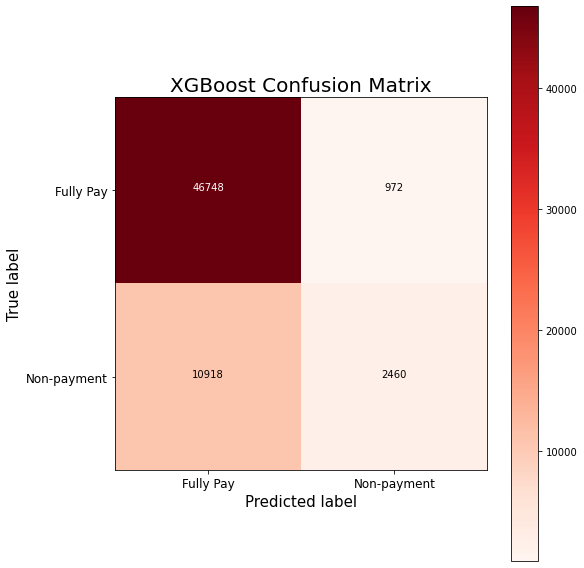

In [6]:
    # Set the size
plt.figure(figsize = (8, 8))

    # Use the function defined above
plot_confusion_matrix(y_pred, 'XGBoost', normalize = False)
plt.show()

### Classsification Report

In [7]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.98      0.89     47720
           1       0.72      0.18      0.29     13378

    accuracy                           0.81     61098
   macro avg       0.76      0.58      0.59     61098
weighted avg       0.79      0.81      0.76     61098



### ROC Curve

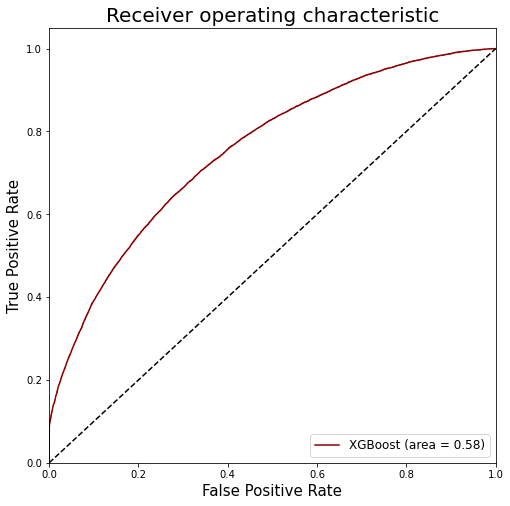

In [8]:
xgb_roc_auc = roc_auc_score(y_val, xgbreg.predict(X_val))
fpr, tpr, thresholds = roc_curve(y_val, xgbreg.predict_proba(X_val)[:,1])
plt.figure(figsize = (8, 8))
plt.plot(fpr, tpr, '#8B0000', label = 'XGBoost (area = %0.2f)' % xgb_roc_auc)
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
fontsize = 12
fontsize_lab = 15
fontsize_tit = 20
plt.xlabel('False Positive Rate', fontsize = fontsize_lab)
plt.ylabel('True Positive Rate', fontsize = fontsize_lab)
plt.title('Receiver operating characteristic', fontsize = fontsize_tit)
plt.legend(loc="lower right", fontsize = fontsize)
plt.savefig('Log_ROC')
plt.show()

In [9]:
    # Parametrize
model = xgbreg
filename = "xgboost.sav"

    # Save the model
pickle.dump(model, open(filename, 'wb'))